In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import datetime as dt
import time
import warnings
plt.style.use('ggplot')

In [2]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [3]:
def data_preprocess(path):
    '''
    read data from path, and preprocess it
    calculate stock price supposing price is 1 at the beginning
    '''
    df = pd.read_csv(path, header=None)
    df.fillna(method="ffill", inplace=True)
    # rename columns
    df.columns = ['label', 'open', 'high', 'low', 'close']
    # calculate price from return
    df['close_price'] = (1+df['close']).cumprod()
    df['high_price'] = (1+df['high'])*df['close_price'].shift(1)
    df['low_price'] = (1+df['low'])*df['close_price'].shift(1)
    df['open_price'] = (1+df['open'])*df['close_price'].shift(1)
    df.fillna(1, inplace=True)
    df['label2'] = df['close_price'].shift(-1)
    # ffill for label2
    df.fillna(method="ffill", inplace=True)
    return df

In [4]:
#Build and train the model
def fit_model_univariate(train,val,timesteps,hl,lr,batch,epochs):
    '''
    The first method, Univariate LSTM, only use close price as input
    '''
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(1,input_shape = (X_train.shape[1],1),return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], return_sequences = True))
        model.add(Dropout(0.2))
    model.add(LSTM(hl[-1]))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate=lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val),
                        verbose = 0, shuffle = False, callbacks=callbacks_list)
    # model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [5]:
# Evaluating the model
def evaluate_model_univariate(model,test,timesteps, sc):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    r2 = r2_score(Y_test,Y_hat)
    return r2, Y_test, Y_hat

In [6]:
def split_data(series, train_percent, val_percent, test_percent):
    '''
    Split data into train, val, test
    '''
    train_data = series[:int(train_percent*len(series))]
    val_data = series[int(train_percent*len(series)):int((train_percent+val_percent)*len(series))]
    test_data = series[int((train_percent+val_percent)*len(series)):int((train_percent+val_percent+test_percent)*len(series))]
    return train_data, val_data, test_data

def transform_data(scalar, all, train, val, test):
    '''
    Normalize data
    '''
    train = scalar.fit_transform(train)
    val = scalar.transform(val)
    test = scalar.transform(test)
    all = scalar.transform(all)
    return train, val, test, all

def run_univariate(df, timesteps, hl, lr, batch_size, num_epochs, train_percent, val_percent, test_percent):
    # Extracting the series
    series = df['close_price']
    series2 = series.values.reshape(-1,1)
    train_data, val_data, test_data = split_data(series2, train_percent, val_percent, test_percent)
    # Normalization
    sc_uni = MinMaxScaler()
    train, val, test, all_data = transform_data(sc_uni, series2, train_data, val_data, test_data)
    model,train_error,val_error = fit_model_univariate(train,val,timesteps,hl,lr,batch_size,num_epochs)
    
    r2_uni, Y_test, Y_hat = evaluate_model_univariate(model, test, timesteps, sc_uni)
    del model
    return r2_uni, Y_test, Y_hat

In [7]:
data = data_preprocess('dataset-20230501.csv')
# set hyperparameters
timesteps = 40
hl = [40,35] # hidden layers
lr = 0.001
batch_size = 64
num_epochs = 150
train_percent = 0.6
val_percent = 0.1
test_percent = 0.1
r2_uni, Y_test, Y_hat = run_univariate(data, timesteps, hl, lr, batch_size, num_epochs, train_percent, val_percent, test_percent)
r2_uni

/var/folders/bw/b76wldrx3mz1kk0lzd4cfrmc0000gn/T/ipykernel_60248/2315794674.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/var/folders/bw/b76wldrx3mz1kk0lzd4cfrmc0000gn/T/ipykernel_60248/2315794674.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/Users/ldvyyc/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


0.4287592279097324

In [8]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

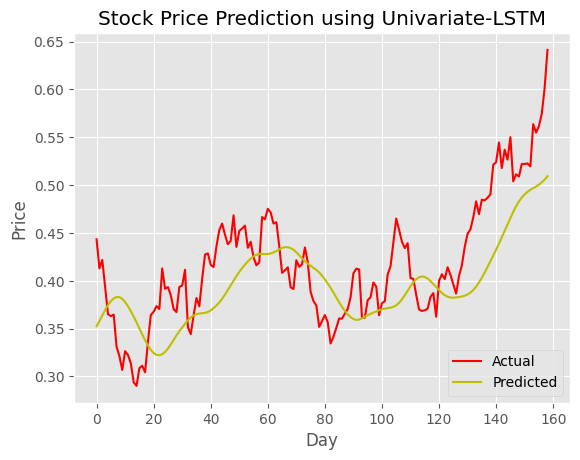

In [9]:
plot_data(Y_test, Y_hat)

(2000, 10)

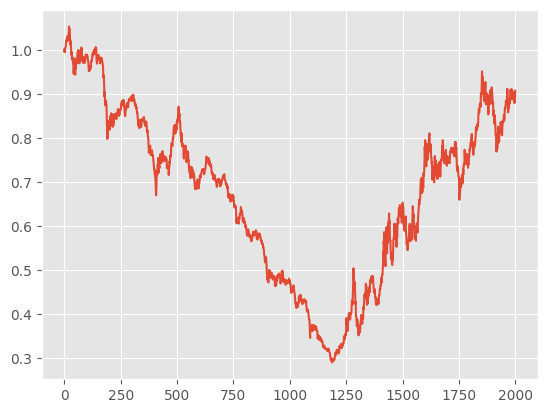

In [10]:
data['close_price'].plot()
data.shape